# EfficientDet Tutorial: inference, eval, and training 



<table align="left"><td>
  <a target="_blank"  href="https://github.com/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

# 0. Install and view graph.

## 0.1 Install package and download source code/image.



In [0]:
#@title
# Install tensorflow and pycocotools
!pip install tensorflow
!pip install pytype
# The default pycocotools doesn't work for python3: https://github.com/cocodataset/cocoapi/issues/49
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientdet" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientdet')
  sys.path.append('.')
else:
  !git pull

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 747kB 50.9MB/s 
  Using cached https://files.pythonhosted.org/packages/cc/bf/32e5dd5cce6543374e4050a7292099402ab80787eddf3732810a55b37763/ninja-1.9.0.post1-py3-none-manylinux1_x86_64.whl
  Created wheel for pytype: filename=pytype-2020.4.1-cp36-cp36m-linux_x86_64.whl size=1703100 sha256=8b8ee389282da429e87ffb44ad909121d5b38ef925dd08d2ce55db2e19050f7f
  Stored in directory: /root/.cache/pip/wheels/12/d5/94/80cf516a1126427248779be76c911e457bec1317ef0e110345
Successfully built pytype
  Created wheel for importlab: filename=importlab-0.5.1-py2.py3-none-any.whl size=21400 sha256=14f507ef0d9a42ee36f9ab3c07c3918734dd224b9308d965d2b9a06554c14186
  Stored in directory: /root/.cache/pip/wheels/23/78/a9/42cd33ab2c683e45bdac8e313f311f7ad44f9590d521b3c2ff
Successfully built importl

In [0]:
MODEL = 'efficientdet-d0'  #@param
# Download checkpoint.
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
!tar zxf {MODEL}.tar.gz
ckpt_path = os.path.join(os.getcwd(), MODEL)
print('Use model in {}'.format(ckpt_path))

--2020-04-15 05:53:08--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28994253 (28M) [application/octet-stream]
Saving to: ‘efficientdet-d0.tar.gz’

efficientdet-d0.tar 100%[===================>]  27.65M  92.9MB/s    in 0.3s    

2020-04-15 05:53:09 (92.9 MB/s) - ‘efficientdet-d0.tar.gz’ saved [28994253/28994253]

Use model in /content/automl/efficientdet/efficientdet-d0


In [0]:
# Prepare image and visualization settings.
image_url =  'https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png'#@param
image_name = 'img.png' #@param
!wget {image_url} -O img.png
import os
img_path = os.path.join(os.getcwd(), 'img.png')

min_score_thresh = 0.4  #@param
max_boxes_to_draw = 200  #@param
line_thickness =   2#@param

import PIL
# Get the largest of height/width and round to 128.
image_size = max(PIL.Image.open(img_path).size)

--2020-04-15 07:00:21--  https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4080549 (3.9M) [image/png]
Saving to: ‘img.png’

img.png             100%[===================>]   3.89M  --.-KB/s    in 0.1s    

2020-04-15 07:00:22 (39.1 MB/s) - ‘img.png’ saved [4080549/4080549]



## 0.2 View graph in TensorBoard

In [0]:
!python model_inspect.py --model_name={MODEL} --logdir=logs &> /dev/null
%load_ext tensorboard
%tensorboard --logdir logs

# 1. inference and serving

## 1.1 Inference a single image.

In [0]:
img_out_dir = os.path.join(os.getcwd(), 'img_out')
if not os.path.exists(img_out_dir):
  os.mkdir(img_out_dir)
  
# Approach 1: use model_inspect.
# !python model_inspect.py --runmode=infer --model_name={MODEL} --ckpt_path={ckpt_path} --input_image={img_path} --output_image_dir={img_out_dir}

# Approach 2: call InferenceDriver
import inference
tf.reset_default_graph()
driver = inference.InferenceDriver(MODEL, ckpt_path, image_size=image_size)
driver.inference(img_path,
                 img_out_dir,
                 min_score_thresh=min_score_thresh,
                 max_boxes_to_draw=max_boxes_to_draw,
                 line_thickness=line_thickness)

INFO:tensorflow:Restoring parameters from /content/automl/efficientdet/efficientdet-d0/model


INFO:tensorflow:Restoring parameters from /content/automl/efficientdet/efficientdet-d0/model


array([[[0.0000000e+00, 6.1250128e+02, 1.3052177e+03, ...,
         1.6317096e+03, 9.0082961e-01, 3.0000000e+00],
        [0.0000000e+00, 8.9684308e+02, 1.2457178e+03, ...,
         1.5820762e+03, 8.7548608e-01, 3.0000000e+00],
        [0.0000000e+00, 6.4375391e+02, 1.5699196e+03, ...,
         1.8987748e+03, 8.7111354e-01, 3.0000000e+00],
        ...,
        [0.0000000e+00, 7.5931934e+02, 6.8410712e+02, ...,
         7.4222101e+02, 2.8789738e-01, 2.7000000e+01],
        [0.0000000e+00, 6.5395575e+02, 7.5595184e+02, ...,
         8.0966974e+02, 2.8620732e-01, 1.0000000e+00],
        [0.0000000e+00, 2.4187918e+02, 1.5080688e+03, ...,
         1.5412715e+03, 2.8509331e-01, 1.0000000e+00]]], dtype=float32)

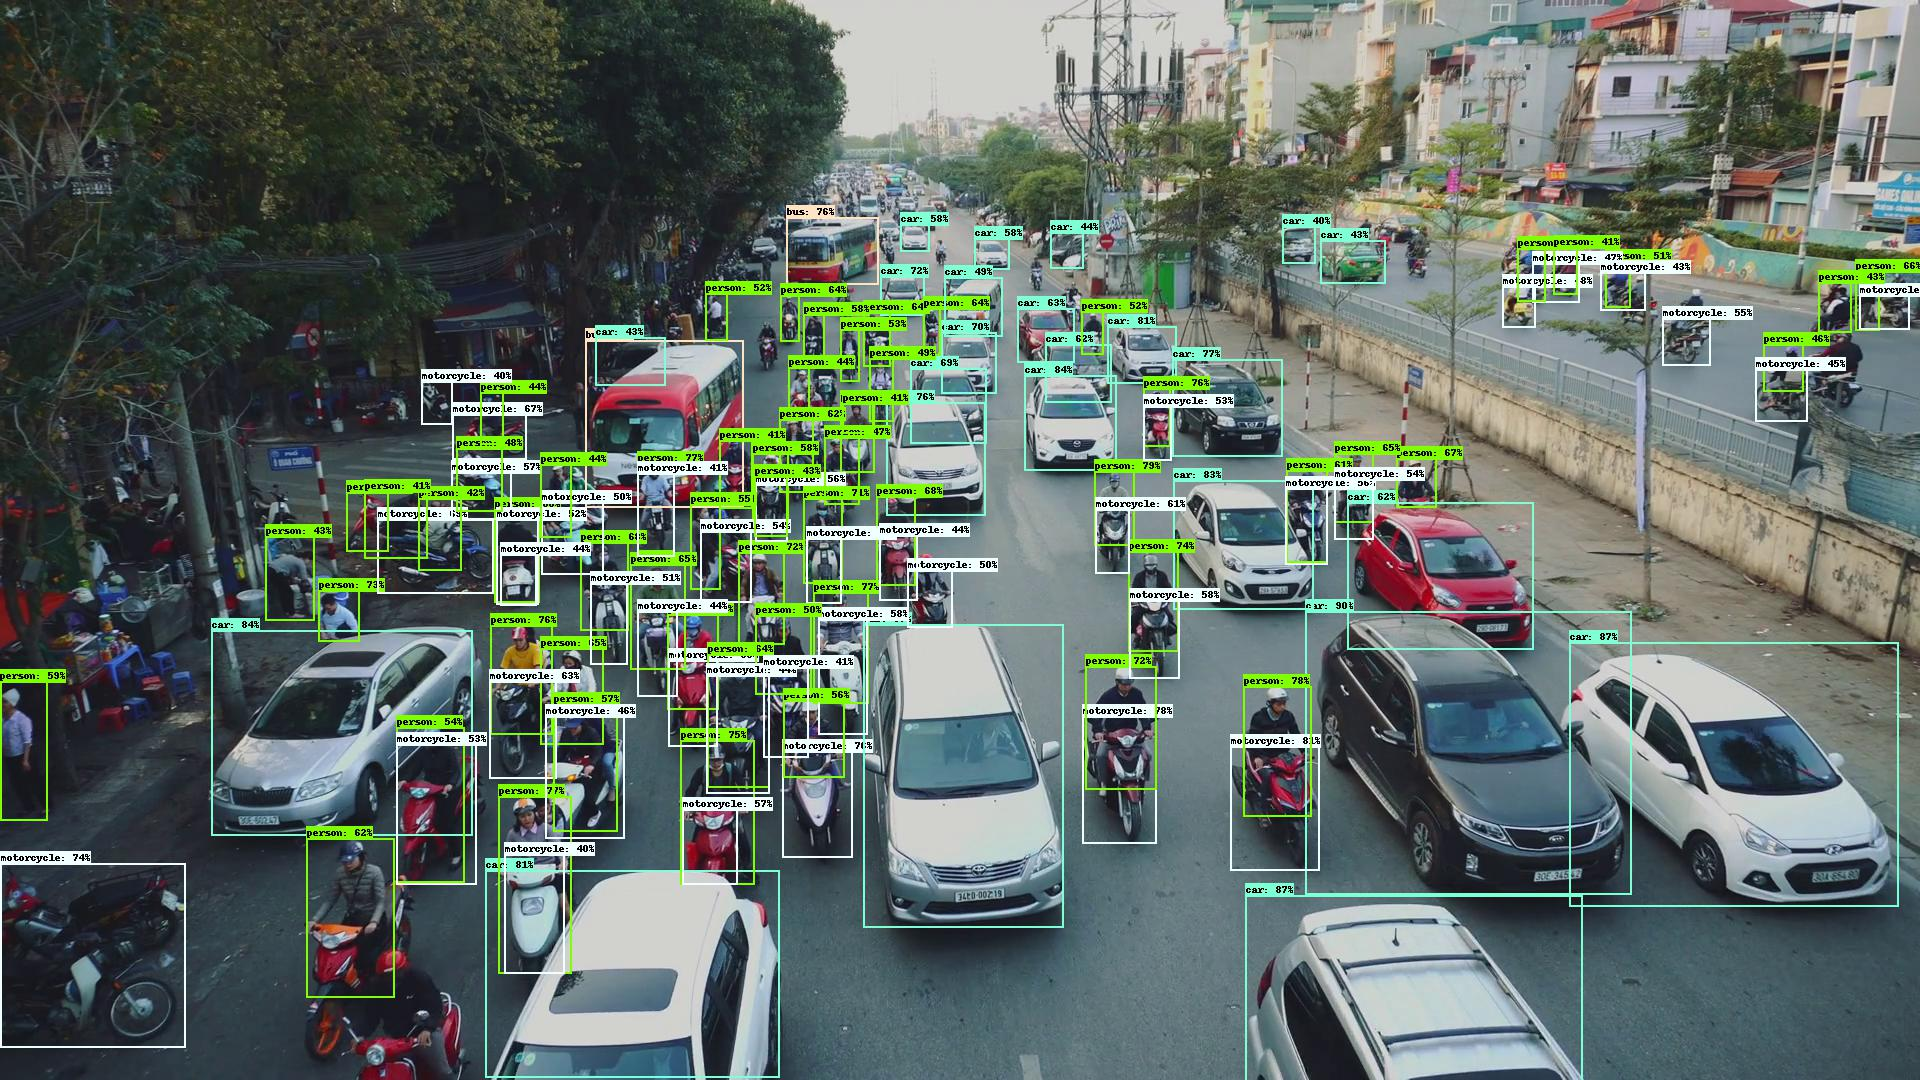

In [0]:
from IPython import display
display.display(display.Image(os.path.join(img_out_dir, '0.jpg')))

## 1.2. Export saved model and do serving.

---



In [0]:
# Export saved model: must specify max_boxes_to_draw, min_score_thresh, and
# image_size when exporrting model (cannot change during serving).
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path={ckpt_path} --saved_model_dir={saved_model_dir} \
  --input_image_size={image_size} --max_boxes_to_draw={max_boxes_to_draw} \
  --min_score_thresh={min_score_thresh}

Instructions for updating:
non-resource variables are not supported in the long term
2020-04-15 07:04:00.677252: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
Use `tf.cast` instead.
W0415 07:04:00.734427 139800052529024 deprecation.py:323] From /content/automl/efficientdet/dataloader.py:105: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.
W0415 07:04:00.738443 139800052529024 deprecation.py:323] From /content/automl/efficientdet/dataloader.py:108: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
If using Keras pass *_constraint arguments t

Instructions for updating:
non-resource variables are not supported in the long term
2020-04-15 07:06:00.566335: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W0415 07:06:00.567113 140564271507328 deprecation.py:323] From /content/automl/efficientdet/inference.py:490: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels

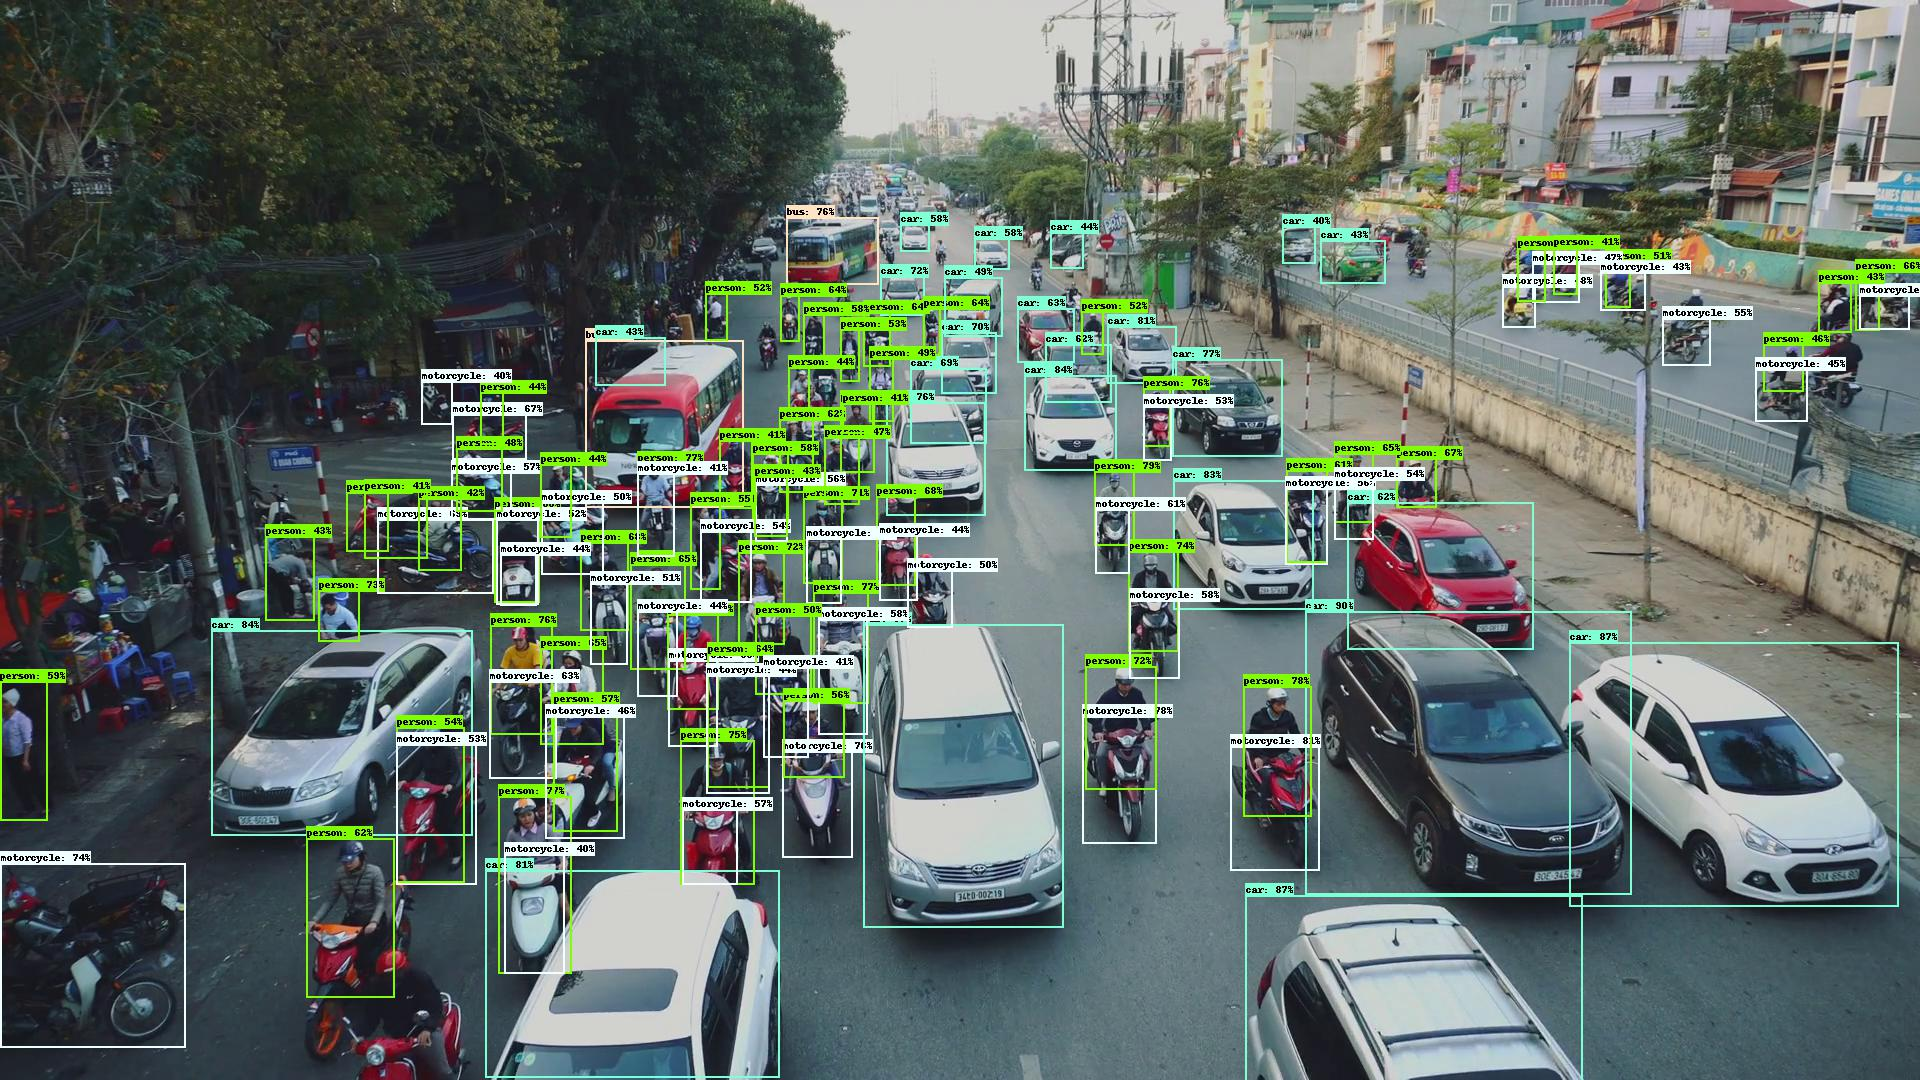

In [0]:
serve_image_out = 'serve_image_out'
!rm -rf {serve_image_out}
!mkdir {serve_image_out}
!python model_inspect.py --runmode=saved_model_infer \
  --saved_model_dir={saved_model_dir} \
  --model_name={MODEL}  --input_image={img_path}  \
  --input_image_size={image_size} \
  --output_image_dir={serve_image_out} \
  --max_boxes_to_draw={max_boxes_to_draw} \
  --min_score_thresh={min_score_thresh} \
  --line_thickness={line_thickness}

from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

## 1.3 Benchmark network latency

In [0]:
!python model_inspect.py --runmode=bm --model_name={MODEL}
# About 15ms for B0 in colab with GPU (Tesla K80).

Instructions for updating:
non-resource variables are not supported in the long term
2020-04-15 05:59:20.230958: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0415 05:59:21.892542 140484351068032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
W0415 05:59:25.215881 140484351068032 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/profiler/in

In [0]:
!for i in 0 1 2 3 4 5 6 7; do python model_inspect.py --runmode=bm --model_name=efficientdet-d${i}; done

# With colab + Tesla K80 GPU, here are the batch size 1 latency summary:
# D0:  16ms,  FPS = 62.5   (batch size 8 FPS=92.8)
# D1:  30ms,  FPS = 33.3   (batch size 8 FPS=41.6)
# D2:  44ms,  FPS = 22.7   (batch size 8 FPS=27.2)
# D3:  79ms,  FPS = 12.7   (batch size 8 FPS=14.4)
# D4: 141ms,  FPS = 7.09
# D5: 299ms,  FPS = 3.34
# D6: 403ms,  FPS = 2.48
# D7: 570ms,  FPS = 1.75

Instructions for updating:
non-resource variables are not supported in the long term
2020-04-15 06:19:00.158938: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0415 06:19:01.773378 140070414595968 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
W0415 06:19:05.014436 140070414595968 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/profiler/in

# 3. COCO evaluation

## 3.1 Run COCO Evaluation on validation set.

In [0]:
if 'val2017' not in os.listdir():
  !wget http://images.cocodataset.org/zips/val2017.zip
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip -q val2017.zip
  !unzip annotations_trainval2017.zip

  !mkdir tfrecrod
  !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
      --image_dir=val2017 \
      --caption_annotations_file=annotations/captions_val2017.json \
      --output_file_prefix=tfrecord/val \
      --num_shards=32

In [0]:
# Evalute on validation set (takes about 10 mins for efficientdet-d0)
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --validation_file_pattern=tfrecord/val*  \
    --val_json_file=annotations/instances_val2017.json  \
    --hparams="use_bfloat16=false" --use_tpu=False

Instructions for updating:
non-resource variables are not supported in the long term

W0405 17:00:48.950480 140678180714368 module_wrapper.py:138] From main.py:222: The name tf.estimator.tpu.TPUConfig is deprecated. Please use tf.compat.v1.estimator.tpu.TPUConfig instead.


W0405 17:00:48.950758 140678180714368 module_wrapper.py:138] From main.py:227: The name tf.estimator.tpu.InputPipelineConfig is deprecated. Please use tf.compat.v1.estimator.tpu.InputPipelineConfig instead.


W0405 17:00:48.950947 140678180714368 module_wrapper.py:138] From main.py:230: The name tf.estimator.tpu.RunConfig is deprecated. Please use tf.compat.v1.estimator.tpu.RunConfig instead.

I0405 17:00:48.951162 140678180714368 main.py:242] {'name': 'efficientdet-d0', 'image_size': 512, 'input_rand_hflip': True, 'train_scale_min': 0.1, 'train_scale_max': 2.0, 'autoaugment_policy': None, 'num_classes': 90, 'skip_crowd_during_training': True, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [(1.0, 

## 3.2 Eval EfficientDets on test-dev.

In [0]:
# Eval on test-dev is slow (~40 mins), please be cautious. 
RUN_EXPENSIVE_TEST_DEV_EVAL = True  #@param

if RUN_EXPENSIVE_TEST_DEV_EVAL == True:
  !rm *.zip *.tar tfrecord/ val2017/   # Cleanup disk space
  # Download and convert test-dev data.
  if "test2017" not in os.listdir():
    !wget http://images.cocodataset.org/zips/test2017.zip
    !unzip -q test2017.zip
    !wget http://images.cocodataset.org/annotations/image_info_test2017.zip
    !unzip image_info_test2017.zip

    !mkdir tfrecrod
    !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
          --image_dir=test2017 \
          --image_info_file=annotations/image_info_test-dev2017.json \
          --output_file_prefix=tfrecord/testdev \
          --num_shards=32

  # Evalute on validation set: non-empty testdev_dir is the key pararmeter.
  # Also, test-dev has 20288 images rather than val 5000 images.
  !mkdir testdev_output
  !python main.py --mode=eval  \
      --model_name={MODEL}  --model_dir={ckpt_path}  \
      --validation_file_pattern=tfrecord/testdev*  \
      --hparams="use_bfloat16=false" --use_tpu=False --eval_batch_size=8 \
      --testdev_dir='testdev_output' --eval_samples=20288
  !rm -rf test2017  # delete images to release disk space.
  # Now you can submit testdev_output/detections_test-dev2017_test_results.json to
  # coco server: https://competitions.codalab.org/competitions/20794#participate

# 4. Training EfficientDets on PASCAL.

## 4.1 Prepare data

In [0]:
# Get pascal voc 2012 trainval data
import os
if 'VOCdevkit' not in os.listdir():
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
  !tar xf VOCtrainval_11-May-2012.tar

  !mkdir tfrecord
  !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_pascal_tfrecord.py  \
    --data_dir=VOCdevkit --year=VOC2012  --output_path=tfrecord/pascal

# Pascal has 5717 train images with 100 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
file_pattern = 'pascal-00000-of-00100.tfrecord'  # @param
images_per_epoch = 57 * len(tf.io.gfile.glob('tfrecord/' + file_pattern))
images_per_epoch = images_per_epoch // 8 * 8  # round to 64.
print('images_per_epoch = {}'.format(images_per_epoch))

## 4.2 Train Pascal VOC 2012 from ImageNet checkpoint for Backbone.

In [0]:
# Train efficientdet from scratch with backbone checkpoint.
backbone_name = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}[MODEL]


# generating train tfrecord is large, so we skip the execution here.
import os
if backbone_name not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckptsaug/{backbone_name}.tar.gz
  !tar xf {backbone_name}.tar.gz

!mkdir /tmp/model_dir
# key option: use --backbone_ckpt rather than --ckpt.
# Don't use ema since we only train a few steps.
!python main.py --mode=train_and_eval \
    --training_file_pattern=tfrecord/{file_pattern} \
    --validation_file_pattern=tfrecord/{file_pattern} \
    --val_json_file=tfrecord/json_pascal.json \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-scratch  \
    --backbone_ckpt={backbone_name} \
    --train_batch_size=8 \
    --eval_batch_size=8 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="use_bfloat16=false,num_classes=20,moving_average_decay=0" \
    --use_tpu=False 

## 4.3 Train Pascal VOC 2012 from COCO checkpoint for the whole net.

In [0]:
# generating train tfrecord is large, so we skip the execution here.
import os
if MODEL not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
  !tar xf {MODEL}.tar.gz

!mkdir /tmp/model_dir/
# key option: use --ckpt rather than --backbone_ckpt.
!python main.py --mode=train_and_eval \
    --training_file_pattern=tfrecord/{file_pattern} \
    --validation_file_pattern=tfrecord/{file_pattern} \
    --val_json_file=tfrecord/json_pascal.json \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-finetune \
    --ckpt={MODEL} \
    --train_batch_size=8 \
    --eval_batch_size=8 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="use_bfloat16=false,num_classes=20,moving_average_decay=0" \
    --use_tpu=False 

## 4.4 View tensorboard for loss and accuracy.


In [0]:
%load_ext tensorboard
%tensorboard --logdir /tmp/model_dir/
# Notably, this is just a demo with almost zero accuracy due to very limited
# training steps, but we can see finetuning has smaller loss than training
# from scratch at the begining.